In [29]:
# pytorch
import torch
from torch import tensor
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# lightning
import pytorch_lightning as L

# other
import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

## Dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

train, valid, test = random_split(mnist, lengths=[.75, .1, .15])

loader_n_workers = os.cpu_count()

train_loader = DataLoader(train, batch_size=64, shuffle=True, num_workers=loader_n_workers)
valid_loader = DataLoader(valid, batch_size=64, shuffle=False, num_workers=loader_n_workers)
test_loader = DataLoader(test, batch_size=64, shuffle=False, num_workers=loader_n_workers)

len(train), len(valid), len(test)

(45000, 6000, 9000)

## Model

In [101]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels: int, n_kernels: int):
        super().__init__()

        kernel_size = 5
        padding = int((kernel_size - 1) / 2) # this is the formula to preserve size assuming a stride of 1

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=n_kernels,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # this downsamples the input by factor of 2
        )

    def forward(self, x):
        return self.layer(x)


class DeConvLayer(nn.Module):
    def __init__(self, in_channels: int, n_kernels: int):
        super().__init__()

        kernel_size = 5
        padding = int((kernel_size - 1) / 2)

        self.layer = nn.ConvTranspose2d(in_channels=in_channels,
                               out_channels=n_kernels,
                               kernel_size=kernel_size,
                               stride=2,
                               padding=padding,
                               output_padding=1
                               ) # upsample the input by factor of 2

    def forward(self, x):
        return self.layer(x)


# ---


class Encoder(nn.Module):
    def __init__(self, n_downsamples: int, n_kernels: int):
        super().__init__()

        self.first_conv = ConvLayer(in_channels=1, n_kernels=n_kernels)

        self.layers = nn.ModuleList()
        for _ in range(n_downsamples - 1):
            self.layers.append(ConvLayer(in_channels=n_kernels, n_kernels=n_kernels))

    def forward(self, x):
        x = self.first_conv(x)

        for layer in self.layers:
            x = layer(x)

        return x


class Decoder(nn.Module):
    def __init__(self, n_upsamples: int, n_kernels: int):
        super().__init__()

        self.non_linearity = nn.ReLU()
        self.final_non_linearity = nn.Sigmoid()

        self.layers = nn.ModuleList()
        for _ in range(n_upsamples - 1):
            self.layers.append(DeConvLayer(in_channels=n_kernels, n_kernels=n_kernels))

        self.final_de_conv = DeConvLayer(in_channels=n_kernels, n_kernels=1)


    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
            x = self.non_linearity(x)

        x = self.final_de_conv(x)
        x = self.final_non_linearity(x)
        return x


# ---


class ConvAutoencoder(L.LightningModule):
    def __init__(self, n_downsamples: int, n_kernels: int):
        super().__init__()
        n_upsamples = n_downsamples

        self.loss_fn = nn.MSELoss()

        self.encoder = Encoder(n_downsamples, n_kernels)
        self.decoder = Decoder(n_upsamples, n_kernels)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def _shared_step(self, batch, batch_idx):
        x, _ = batch
        y = x # because autoencoder
        y = y.view(-1, 1, 28, 28)

        output = self.forward(x)
        output = output.view(-1, 1, 28, 28)
        loss = self.loss_fn(output, y)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._shared_step(batch, batch_idx)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._shared_step(batch, batch_idx)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._shared_step(batch, batch_idx)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(lr=0.001, params=self.parameters())


In [107]:
ex_input = torch.randn(5, 1, 28, 28)

model = ConvAutoencoder(2, 1)

output = model(ex_input)

output.shape

torch.Size([5, 1, 28, 28])

In [111]:
log_save_dir = 'autoencoder_logs'


n_downsamples = 1
n_kernels = 15
epochs = 10

model = ConvAutoencoder(n_downsamples, n_kernels)

trainer = L.Trainer(
    logger=L.loggers.CSVLogger(save_dir=log_save_dir),
    max_epochs=epochs
)

trainer.fit(
    model, 
    train_loader, 
    valid_loader,
)

logs_df = get_latest_logs_as_df(log_save_dir)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | loss_fn | MSELoss | 0     
1 | encoder | Encoder | 390   
2 | decoder | Decoder | 376   
------------------------------------
766       Trainable params
0         Non-trainable params
766       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


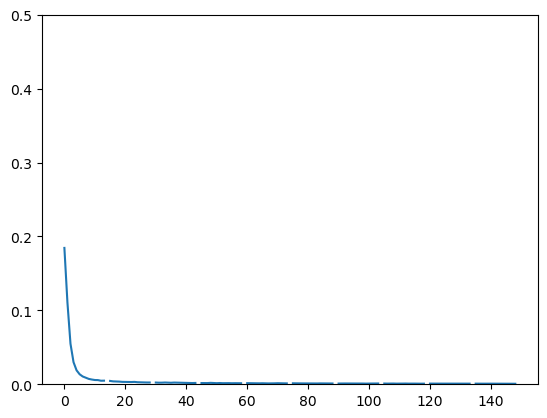

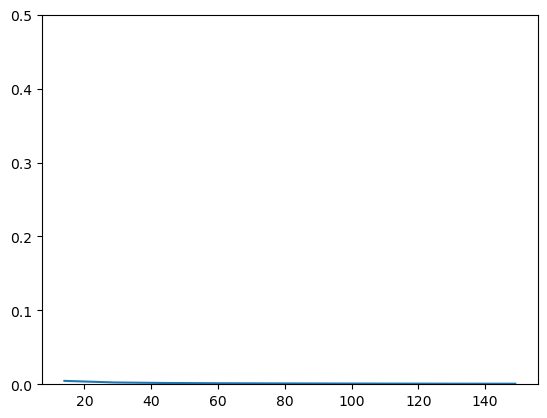

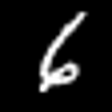

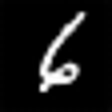

In [112]:
# logs_df

y_max = 0.5

logs_df.train_loss.plot()
plt.ylim(0, y_max)
plt.show()
(
    logs_df
    .query('val_loss.notna()', engine='python')
    .val_loss
).plot()
plt.ylim(0, y_max)
plt.show()


# visual test

test_ex = test[0][0]
display_tensor_as_image(test_ex)
display_tensor_as_image(model(test_ex))

In [80]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0007599703385494649   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0007599703385494649}]

## Visualization utils

In [7]:
from pathlib import Path

def get_latest_logs_as_df(log_save_dir) -> pd.DataFrame:
    log_versions_dir = f'{log_save_dir}/lightning_logs'
    latest_log_dir = os.listdir(log_versions_dir)[-1]
    latest_csv = f'{log_versions_dir}/{latest_log_dir}/metrics.csv'

    return pd.read_csv(latest_csv)


def display_tensor_as_image(tensor):
    to_img = transforms.ToPILImage()
    tensor = tensor.view(28, 28)
    img: Image.Image = to_img(tensor)
    img = img.resize((28*4, 28*4))
    display(img)
